In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import albumentations as A
import cv2
import itertools
import os
import time
from pathlib import Path
from tqdm.notebook import tqdm
import math
from scipy import ndimage

# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

torch.manual_seed(3)

#https://github.com/mcordts/cityscapesScripts

## Data

1. To get the data go to https://www.cityscapes-dataset.com/ and register. Then download these files:
`gtFine_trainvaltest.zip` and `leftImg8bit_trainvaltest.zip`. Put the data in your gpu and unzip.

2. Go to directory `utils` open the file `preprocess_data.py` and replace the following paths
`cityscapes_data_path` and `cityscapes_meta_path`.

3. Run `python preprocess_data.py`

In [2]:
PATH = Path('/data2/yinterian/cityscapes/')

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [4]:
list((PATH/"leftImg8bit/train/zurich").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000051_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000092_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000117_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000003_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000071_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000040_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000121_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000048_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/train/zurich/zurich_000045_000019_leftImg8bit.png'),
 PosixPath('/data2/yinterian/cityscapes/leftImg8bit/tra

(<matplotlib.image.AxesImage at 0x7f266446a580>, (1024, 2048, 3))

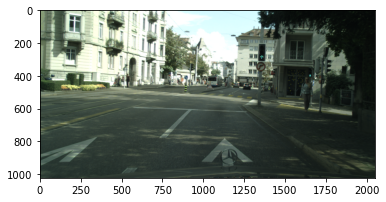

In [9]:
path = PATH/"leftImg8bit/train/zurich/zurich_000051_000019_leftImg8bit.png"
im1 = read_image(path)
plt.imshow(im1), im1.shape

(<matplotlib.image.AxesImage at 0x7f2664440c70>, (1024, 2048, 3))

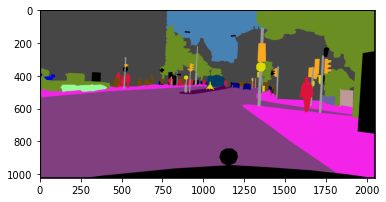

In [10]:
path = PATH/"gtFine/train/zurich/zurich_000051_000019_gtFine_color.png"
im2 = read_image(path)
plt.imshow(im2), im2.shape

In [5]:
list((PATH/"meta").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/meta/label_imgs'),
 PosixPath('/data2/yinterian/cityscapes/meta/class_weights.pkl')]

In [7]:
list((PATH/"meta/label_imgs").iterdir())[:10] 

[PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/bremen_000260_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/weimar_000005_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/ulm_000048_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/stuttgart_000139_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/cologne_000012_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/krefeld_000000_022162.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/hanover_000000_030781.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/darmstadt_000027_000019.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/hanover_000000_045841.png'),
 PosixPath('/data2/yinterian/cityscapes/meta/label_imgs/tubingen_000090_000019.png')]

(<matplotlib.image.AxesImage at 0x7f34f0719b20>, (1024, 2048, 3))

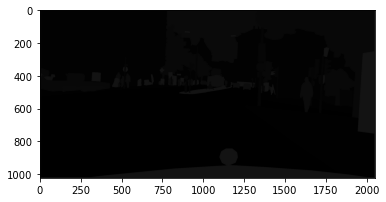

In [8]:
path = PATH/"meta/label_imgs/zurich_000051_000019.png"
im = read_image(path)
plt.imshow(im), im.shape

In [22]:
(im[:,:,0] == im[:,:,2]).sum(), 1024*2048

(2097152, 2097152)

In [23]:
im.reshape(-1).min(), im.reshape(-1).max()

(0, 19)

## albumentations for data augmentation 

In [16]:
crop = (2000, 1000)
transformImg = A.Compose([A.RandomCrop(width=crop[0],height=crop[1]),
                      A.HorizontalFlip(p=.5),
                      A.VerticalFlip(p=.5),
                      A.Rotate(limit = 20, border_mode = cv2.BORDER_CONSTANT, value = 0.0, p = .75),
                      A.GridDistortion(border_mode=cv2.BORDER_CONSTANT, value=0.0, p=0.75)])          

In [26]:
transformed = transformImg(image=im1, mask=im2) 

In [27]:
img = transformed['image']
mask = transformed['mask']

(<matplotlib.image.AxesImage at 0x7f265ffc46d0>, (1000, 2000, 3))

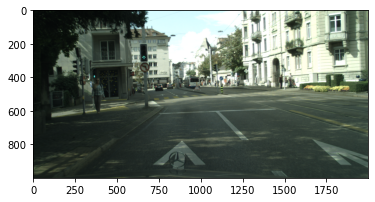

In [28]:
plt.imshow(img), img.shape

(<matplotlib.image.AxesImage at 0x7f26641653a0>, (1000, 2000, 3))

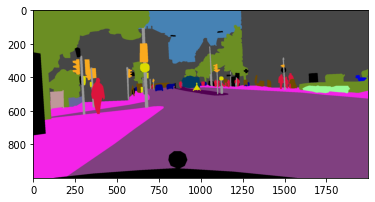

In [29]:
plt.imshow(mask), mask.shape